## Gridded Earth Systems Data

Since we're using general-purpose libraries like xarray, we can translate concepts between kinds of data.

In [3]:
import fsspec
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib
import matplotlib.animation
import pandas as pd

In [2]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(64)
client = cluster.get_client()
cluster

We host the [Daymet](https://aka.ms/ai4edata-daymet) dataset in a cloud-optimized Zarr format. It contains daily estimates for variables like precipitation and temperature for North America on a 1 kilometer grid.

In [4]:
%%time
store = fsspec.get_mapper('az://daymet-zarr/daily/na.zarr', account_name="daymeteuwest")
ds = xr.open_zarr(store, consolidated=True)
ds

CPU times: user 1.08 s, sys: 75.1 ms, total: 1.16 s
Wall time: 1.43 s


<xarray.Dataset>
Dimensions:                  (nv: 2, time: 14600, x: 7814, y: 8075)
Coordinates:
    lat                      (y, x) float32 dask.array<chunksize=(505, 977), meta=np.ndarray>
    lon                      (y, x) float32 dask.array<chunksize=(505, 977), meta=np.ndarray>
  * time                     (time) datetime64[ns] 1980-01-01T12:00:00 ... 20...
  * x                        (x) float32 -4.56e+06 -4.559e+06 ... 3.253e+06
  * y                        (y) float32 4.984e+06 4.983e+06 ... -3.09e+06
Dimensions without coordinates: nv
Data variables:
    dayl                     (time, y, x) float32 dask.array<chunksize=(365, 584, 284), meta=np.ndarray>
    lambert_conformal_conic  int16 ...
    prcp                     (time, y, x) float32 dask.array<chunksize=(365, 584, 284), meta=np.ndarray>
    srad                     (time, y, x) float32 dask.array<chunksize=(365, 584, 284), meta=np.ndarray>
    swe                      (time, y, x) float32 dask.array<chunksize=(365, 584, 284), meta=np.ndarray>
    time_bnds                (time, nv) datetime64[ns] dask.array<chunksize=(14600, 2), meta=np.ndarray>
    tmax                     (time, y, x) float32 dask.array<chunksize=(365, 584, 284), meta=np.ndarray>
    tmin                     (time, y, x) float32 dask.array<chunksize=(365, 584, 284), meta=np.ndarray>
    vp                       (time, y, x) float32 dask.array<chunksize=(365, 584, 284), meta=np.ndarray>
    yearday                  (time) int16 dask.array<chunksize=(14600,), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.6
    Version_data:      Daymet Data Version 4.0
    Version_software:  Daymet Software Version 4.0
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:        Please see http://daymet.ornl.gov/ for current informa...
    source:            Daymet Software Version 4.0
    start_year:        [1980]

Our analysis looks very similar to before. For example, we can compute the average maximum daily temperature over a small slice.

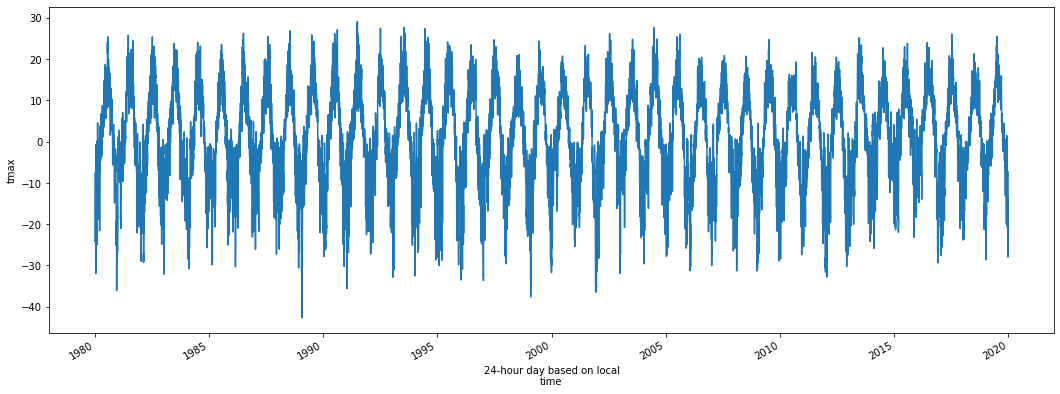

In [5]:
ts = (
    ds['tmax']
      .sel(y=slice(3_050_000, 3_001_000),
           x=slice(-2_600_000, -2_550_000))
      .mean(dim=["x", "y"])
      .compute()
)

fig, ax = plt.subplots(figsize=(18, 6))
ts.plot(ax=ax);

In [6]:
data = ds['tmax'].sel(y=slice(3_050_000, 500_648), x=slice(-2_600_000, -500_000))
data

<xarray.DataArray 'tmax' (time: 14600, y: 2550, x: 2100)>
dask.array<getitem, shape=(14600, 2550, 2100), dtype=float32, chunksize=(365, 584, 284), chunktype=numpy.ndarray>
Coordinates:
    lat      (y, x) float32 dask.array<chunksize=(86, 970), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(86, 970), meta=np.ndarray>
  * time     (time) datetime64[ns] 1980-01-01T12:00:00 ... 2019-12-31T12:00:00
  * x        (x) float32 -2.599e+06 -2.598e+06 ... -5.012e+05 -5.002e+05
  * y        (y) float32 3.05e+06 3.049e+06 3.048e+06 ... 5.02e+05 5.01e+05
Attributes:
    cell_methods:  area: mean time: maximum
    grid_mapping:  lambert_conformal_conic
    long_name:     daily maximum temperature
    units:         degrees C

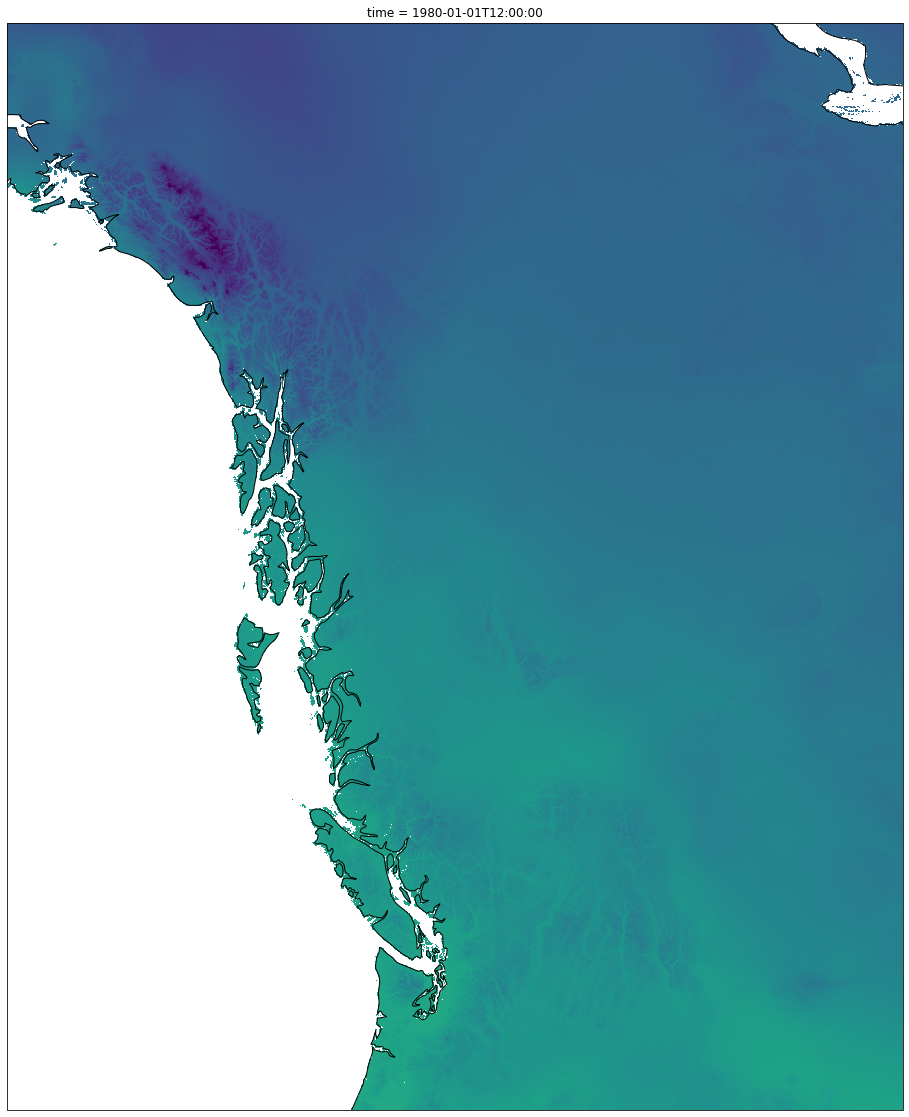

In [7]:
attrs = ds.lambert_conformal_conic.attrs
central_longitude = attrs['longitude_of_central_meridian'][0]
central_latitude = attrs['latitude_of_projection_origin'][0]
false_easting = attrs["false_easting"][0]
false_northing = attrs["false_northing"][0]
standard_parallels = attrs["standard_parallel"]

fig, ax = plt.subplots(figsize=(20, 20),
                       subplot_kw=dict(projection=ccrs.LambertConformal(
                           central_longitude=-100, central_latitude=central_latitude, false_easting=false_easting,
                           false_northing=false_northing, standard_parallels=standard_parallels
                       )))
ax.coastlines()

a = data.isel(time=0).compute()
image = a.plot.imshow(add_colorbar=False, cmap="viridis", animated=True, ax=ax)

```
%%time
def animate(frame):
    frame = data.isel(time=frame)

    image.set_data(frame.data)
    return [image]

anim = matplotlib.animation.FuncAnimation(fig, animate, frames=360 * 3,
                                          interval=20, blit=True)
anim.save('basic_animation.mp4', fps=12, extra_args=['-vcodec', 'libx264'],
          progress_callback=lambda i, n: print(f'Saving frame {i} of {n}', end='\r'))
          
# CPU times: user 5min 15s, sys: 21.9 s, total: 5min 37s
# Wall time: 8min 12s
```

In [7]:
from IPython.display import Video
Video("basic_animation.mp4")